In [31]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout

# Data Loader

In [7]:
df=pd.read_csv('../dataset/train.csv')
df

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
987995,20230530,A189980,흥국에프엔비,272284,3005,3035,2955,2980
987996,20230530,A000540,흥국화재,50218,3250,3255,3195,3215
987997,20230530,A003280,흥아해운,130664,1344,1395,1340,1370
987998,20230530,A037440,희림,141932,9170,9260,9170,9200


In [9]:
df = df[df['종목코드']=='A000120']
df

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
16,20210601,A000120,CJ대한통운,46783,170000,170500,168500,169500
2016,20210602,A000120,CJ대한통운,48773,169500,170500,168000,168500
4016,20210603,A000120,CJ대한통운,46776,168500,170000,168000,170000
6016,20210604,A000120,CJ대한통운,76675,168500,169500,166500,167000
8016,20210607,A000120,CJ대한통운,49827,167000,168000,166000,166500
...,...,...,...,...,...,...,...,...
978016,20230523,A000120,CJ대한통운,45524,83100,85100,82500,84200
980016,20230524,A000120,CJ대한통운,57215,83700,85800,83500,85600
982016,20230525,A000120,CJ대한통운,48707,84600,85400,83000,83000
984016,20230526,A000120,CJ대한통운,26045,82600,84100,82100,83700


In [10]:
df.shape

(494, 8)

# MinMaxScaler() 정의

In [11]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0) # 각 열에서 최솟값을 제하여 0을 기준으로 Data를 정규화
    denominator = np.max(data, 0) - np.min(data, 0) # 각 열에서 최댓값-최소값하여 정규화의 분모를 구함

    return numerator / (denominator + 1e-7) # 각 Factor를 해당 열의 최댓값-최솟값으로 나눠 0~1 사이의 값을 갖도록 함

In [40]:
dfx = df[['시가', '고가', '저가', '종가', '거래량']]
dfx = MinMaxScaler(dfx) # dfx 데이터를 정규화

dfy = dfx[['종가']]
dfx = dfx[['시가', '고가', '저가', '거래량']]

dfx

,시가,고가,저가,거래량
16,0.858577,0.857537,0.873596,0.024357
2016,0.854015,0.857537,0.868914,0.025951
4016,0.844891,0.852941,0.868914,0.024352
6016,0.844891,0.848346,0.854869,0.048303
8016,0.831204,0.834559,0.850187,0.026796
...,...,...,...,...
978016,0.065693,0.072610,0.068352,0.023349
980016,0.071168,0.079044,0.077715,0.032714
982016,0.079380,0.075368,0.073034,0.025899
984016,0.061131,0.063419,0.064607,0.007744


In [41]:
dfx.describe() #주요 통계량을 알림. 개수나 4분위 수 등

,시가,고가,저가,거래량
count,494.000000,494.000000,494.000000,494.000000
mean,0.405817,0.410323,0.408149,0.028630
std,0.285500,0.290037,0.290604,0.050084
min,0.000000,0.000000,0.000000,0.000000
25%,0.131387,0.127528,0.129448,0.011691
50%,0.411496,0.420956,0.419476,0.019576
75%,0.539234,0.543888,0.541199,0.033365
max,1.000000,1.000000,1.000000,1.000000


In [42]:
dfy.head()

,종가
16,0.857929
2016,0.848763
4016,0.862511
6016,0.835014
8016,0.830431


In [43]:
time_step = 10
step = 1

def create_dataset(X, y, time_step, step):
    Xs, ys = [], []

    for i in range(0, len(X) - time_step, step): #X길이를 벗어나지 않는 선에서 step에 따라 dataset 생성
        v = X.iloc[i : (i + time_step)].values
        labels = y.iloc[i + time_step]

        Xs.append(v) # Xs list에 v를 추가
        ys.append(labels) # 그리고 라벨추가

    return np.array(Xs), np.array(ys) # Xs, ys를 각각 numpy배열로 변환하여 반환

In [44]:
X, y = create_dataset(dfx, dfy, time_step, step)

X.shape

(484, 10, 4)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((324, 10, 4), (160, 10, 4), (324, 1), (160, 1))

# RNN

In [46]:
model = Sequential([
    SimpleRNN(20, activation='relu', input_shape=(X.shape[1:]), return_sequences=True),
    Dropout(0.5), # Dropout layer: 과적합방지
    SimpleRNN(20, activation='relu'),
    Dropout(0.3),
    Dense(1) # Dense layer: 출력을 생성
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 10, 20)            500       
                                                                 
 dropout_4 (Dropout)         (None, 10, 20)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 20)                820       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1341 (5.24 KB)
Trainable params: 1341 (5.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [47]:
model.compile(loss='mse', optimizer='adam') # loss로 mse(평균제곱오차)

In [48]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.33, shuffle=False)

Epoch 1/500
7/7 [==============================] - 2s 56ms/step - loss: 0.4718 - val_loss: 0.0162
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 0.2284 - val_loss: 0.0074
Epoch 3/500
7/7 [==============================] - 0s 9ms/step - loss: 0.2119 - val_loss: 0.0194
Epoch 4/500
7/7 [==============================] - 0s 10ms/step - loss: 0.1862 - val_loss: 0.0346
Epoch 5/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1758 - val_loss: 0.0317
Epoch 6/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1253 - val_loss: 0.0213
Epoch 7/500
7/7 [==============================] - 0s 9ms/step - loss: 0.1358 - val_loss: 0.0154
Epoch 8/500
7/7 [==============================] - 0s 10ms/step - loss: 0.1376 - val_loss: 0.0278
Epoch 9/500
7/7 [==============================] - 0s 10ms/step - loss: 0.1298 - val_loss: 0.0320
Epoch 10/500
7/7 [==============================] - 0s 10ms/step - loss: 0.1142 - val_loss: 0.0257
Epoch 11/500
7/7 [=====

7/7 [==============================] - 0s 8ms/step - loss: 0.0230 - val_loss: 0.0082
Epoch 85/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0254 - val_loss: 0.0085
Epoch 86/500
7/7 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0085
Epoch 87/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0223 - val_loss: 0.0088
Epoch 88/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0225 - val_loss: 0.0090
Epoch 89/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0232 - val_loss: 0.0093
Epoch 90/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0204 - val_loss: 0.0095
Epoch 91/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0226 - val_loss: 0.0096
Epoch 92/500
7/7 [==============================] - 0s 8ms/step - loss: 0.0219 - val_loss: 0.0100
Epoch 93/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0256 - val_loss: 0.0096
Epoch 94/500
7/7 [===============

Epoch 167/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0123 - val_loss: 0.0104
Epoch 168/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 169/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0132 - val_loss: 0.0110
Epoch 170/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 171/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0145 - val_loss: 0.0116
Epoch 172/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0100 - val_loss: 0.0110
Epoch 173/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0094 - val_loss: 0.0116
Epoch 174/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 175/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0096 - val_loss: 0.0114
Epoch 176/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0127 - val_loss: 0.0117
Epoch 17

7/7 [==============================] - 0s 9ms/step - loss: 0.0075 - val_loss: 0.0132
Epoch 250/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0062 - val_loss: 0.0134
Epoch 251/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0070 - val_loss: 0.0136
Epoch 252/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0057 - val_loss: 0.0138
Epoch 253/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0095 - val_loss: 0.0138
Epoch 254/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0136
Epoch 255/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0138
Epoch 256/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0061 - val_loss: 0.0138
Epoch 257/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0067 - val_loss: 0.0139
Epoch 258/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0070 - val_loss: 0.0138
Epoch 259/500
7/7 [==

7/7 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0179
Epoch 332/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0178
Epoch 333/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0180
Epoch 334/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0065 - val_loss: 0.0179
Epoch 335/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0055 - val_loss: 0.0180
Epoch 336/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0181
Epoch 337/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0179
Epoch 338/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0183
Epoch 339/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0183
Epoch 340/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0056 - val_loss: 0.0183
Epoch 341/500
7/7 [=====

7/7 [==============================] - 0s 9ms/step - loss: 0.0059 - val_loss: 0.0190
Epoch 414/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0192
Epoch 415/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0192
Epoch 416/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0189
Epoch 417/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0192
Epoch 418/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0068 - val_loss: 0.0188
Epoch 419/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0069 - val_loss: 0.0192
Epoch 420/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0063 - val_loss: 0.0191
Epoch 421/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0046 - val_loss: 0.0193
Epoch 422/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0052 - val_loss: 0.0191
Epoch 423/500
7/7 [===

7/7 [==============================] - 0s 9ms/step - loss: 0.0060 - val_loss: 0.0189
Epoch 496/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0044 - val_loss: 0.0186
Epoch 497/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0191
Epoch 498/500
7/7 [==============================] - 0s 10ms/step - loss: 0.0042 - val_loss: 0.0189
Epoch 499/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0186
Epoch 500/500
7/7 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0186


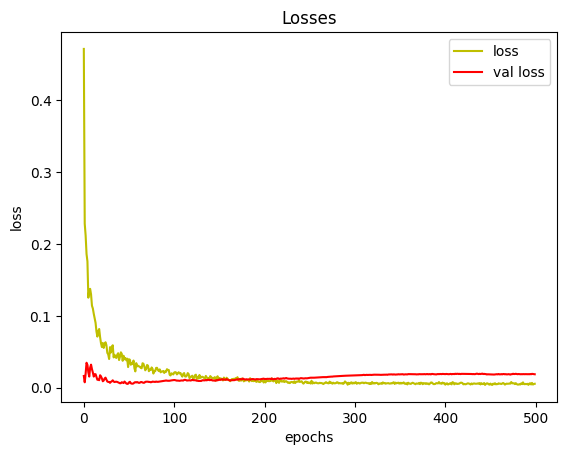

In [49]:
loss = history.history['loss']
val_loss = history.history['val_loss']

x = np.arange(0, len(history.history['loss']))

plt.plot(x, loss, 'y', label='loss')
plt.plot(x, val_loss, 'r', label='val loss')
plt.title('Losses')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [50]:
y_pred = model.predict(X_test)

5/5 [==============================] - 0s 2ms/step


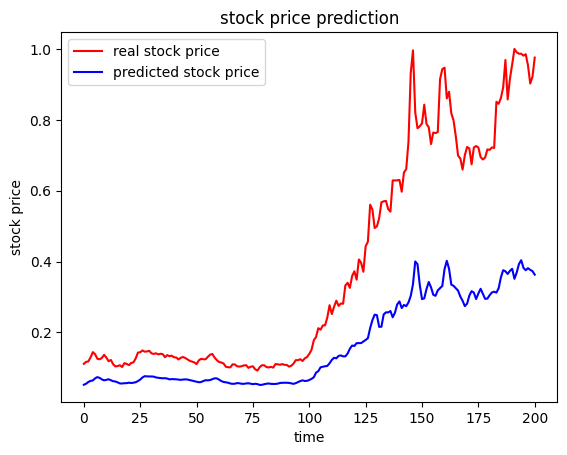

In [18]:
y_pred.shape

plt.plot(y_test, color='red', label='real stock price')
plt.plot(y_pred, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# LSTM

In [51]:
# 두 데이터를 리스트 형태로 저장
X1 = dfx.values.tolist()
y1 = dfy.values.tolist()

In [52]:
window_size = 20

data_X = []
data_y = []
for i in range(len(y1) - window_size):
    _X = X1[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y1[i + window_size]     # 다음 날 종가
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.01277372262772557, 0.0009191176470579787, 0.0, 0.04964852058206998], [0.0, 0.008272058823521809, 0.006554307116098732, 0.023294974345004726], [0.008211678832109296, 0.008272058823521809, 0.01029962546815515, 0.006617025622949174], [0.014598540145972082, 0.010110294117637766, 0.015917602996239778, 0.013918985496215727], [0.010036496350355806, 0.022977941176449468, 0.01217228464418336, 0.03001373873963847], [0.0264598540145744, 0.02757352941173936, 0.029962546816451347, 0.028611826531386525], [0.0364963503649302, 0.05514705882347872, 0.04307116104864881, 0.08392327134210392], [0.06204379562038135, 0.0652573529411165, 0.06647940074900142, 0.05999222940089803], [0.06386861313862785, 0.06341911764700053, 0.06835205992502963, 0.03757284936653295], [0.0729927007298604, 0.06158088235288458, 0.06367041198495911, 0.014901926227372946], [0.05383211678827205, 0.04411764705878298, 0.04962546816474754, 0.005510716617465783], [0.0529197080291488, 0.043198529411725, 0.05337078651680396, 0.00407195

In [53]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))

전체 데이터의 크기 : 474 474


In [54]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', train_X.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_X.shape, test_y.shape)

훈련 데이터의 크기 : (331, 20, 4) (331, 1)
테스트 데이터의 크기 : (143, 20, 4) (143, 1)


In [57]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(20, 4)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 20)            2000      
                                                                 
 dropout_8 (Dropout)         (None, 20, 20)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5301 (20.71 KB)
Trainable params: 5301 (20.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

Epoch 1/70
12/12 [==============================] - 2s 14ms/step - loss: 0.2458
Epoch 2/70
12/12 [==============================] - 0s 13ms/step - loss: 0.1354
Epoch 3/70
12/12 [==============================] - 0s 12ms/step - loss: 0.0320
Epoch 4/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0178
Epoch 5/70
12/12 [==============================] - 0s 12ms/step - loss: 0.0214
Epoch 6/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0160
Epoch 7/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0136
Epoch 8/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0127
Epoch 9/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0114
Epoch 10/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0111
Epoch 11/70
12/12 [==============================] - 0s 12ms/step - loss: 0.0115
Epoch 12/70
12/12 [==============================] - 0s 11ms/step - loss: 0.0104
Epoch 13/70
12/12 [==================

In [59]:
model.evaluate(test_X, test_y)

5/5 [==============================] - 0s 6ms/step - loss: 0.0037


0.0036729881539940834

5/5 [==============================] - 0s 4ms/step


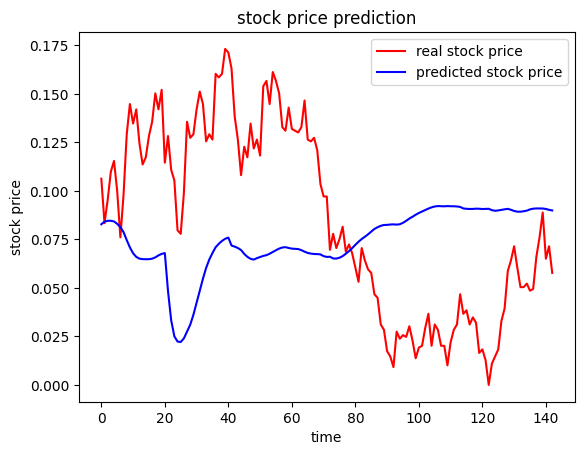

In [60]:
pred_y = model.predict(test_X)

plt.figure()
plt.plot(test_y, color='red', label='real stock price')
plt.plot(pred_y, color='blue', label='predicted stock price')
plt.title('stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()